<a href="https://colab.research.google.com/github/lschanne/melanoma-detection/blob/Sharon/Melanoma_metadata%2BProb_classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

from skimage import img_as_uint
from skimage.io import imshow, imread
from skimage.color import rgb2hsv
from skimage.color import rgb2gray

import os
from PIL import Image
import glob, random

# Load Data set


In [3]:
# Read file from github
data_meta = pd.read_csv('train.csv')
data_7525 = pd.read_csv('https://raw.githubusercontent.com/lschanne/melanoma-detection/Lingyao/concatenated_7525.csv')
data_whole = pd.read_csv('https://raw.githubusercontent.com/lschanne/melanoma-detection/Lingyao/concatenated_whole.csv')
#data_whole.head()
#print(data.shape)
#print(data.columns)

In [4]:
print(data_meta.shape)
data_meta.isnull().sum()

(33126, 9)


image_name                         0
patient_id                         0
lesion_id                          0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [5]:
# run whole data 
print(data_whole.shape)
data_whole.isnull().sum()

(33126, 10)


Unnamed: 0                         0
prob_malignant                     0
image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [6]:
data_whole.loc[data_whole['target'] == 0,]

,Unnamed: 0,prob_malignant,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,0,0.000056,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
1,1,0.001415,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
2,2,0.003143,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
3,3,0.000022,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
4,4,0.000797,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...,...,...
32537,32537,0.374943,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
32538,32538,0.000192,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
32539,32539,0.082951,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
32540,32540,0.004475,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [7]:
print(data_7525.shape)
data_7525.isnull().sum()
data_7525.head(5)

(2384, 10)


,Unnamed: 0,prob_malignant,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,0,0.001415,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
1,1,0.426795,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0
2,2,0.000626,ISIC_0087290,IP_4050705,female,40.0,torso,unknown,benign,0
3,3,0.004178,ISIC_0106091,IP_4050705,female,40.0,torso,unknown,benign,0
4,4,0.004114,ISIC_0109415,IP_6342052,male,65.0,torso,unknown,benign,0


# Read & Data Split



In [89]:
# select data & columns to use 

data = data_meta
col_used = ['sex', 'age_approx','anatom_site_general_challenge','target']

data = data.loc[:,col_used]
data.head()

,sex,age_approx,anatom_site_general_challenge,target
0,male,45.0,head/neck,0
1,female,45.0,upper extremity,0
2,female,50.0,lower extremity,0
3,female,45.0,head/neck,0
4,female,55.0,upper extremity,0


In [90]:
# no need for linear regression
data['target'].value_counts()
data['target'].value_counts()/np.float(len(data))


0    0.98237
1    0.01763
Name: target, dtype: float64

In [91]:
# spliting data set 
train, test = train_test_split(data, test_size = 0.2, random_state = 0)

In [92]:
train.shape

(26500, 4)

In [93]:
test.shape

(6626, 4)

In [94]:
train['target'].value_counts()


0    26031
1      469
Name: target, dtype: int64

In [95]:
test['target'].value_counts()

0    6511
1     115
Name: target, dtype: int64

In [96]:
# Split dataset
X_train = train.drop(['target'], axis=1)
y_train = train['target']
X_test = test.drop(['target'], axis=1)
y_test = test['target']




In [97]:
X_test.head

<bound method NDFrame.head of           sex  age_approx anatom_site_general_challenge
30482  female        45.0               upper extremity
32924  female        45.0               upper extremity
13133    male        45.0               upper extremity
10851    male        65.0               upper extremity
23966    male        30.0                         torso
...       ...         ...                           ...
8136     male        70.0                         torso
2764     male        55.0                         torso
26987    male        65.0                     head/neck
22505  female        35.0               upper extremity
2731     male        80.0                         torso

[6626 rows x 3 columns]>

In [98]:
X_train.isnull().sum()


sex                               52
age_approx                        55
anatom_site_general_challenge    421
dtype: int64

In [99]:
X_test.isnull().sum()

sex                               13
age_approx                        13
anatom_site_general_challenge    106
dtype: int64

In [100]:
y_train.isnull().sum()

0

# Data Encoding & Imputing

In [101]:
cat = ['sex','anatom_site_general_challenge' ]
num = ['age_approx']

catagorical_data = X_train.drop(num,axis =1)
catagorical_data.head(5)

,sex,anatom_site_general_challenge
21086,male,torso
15202,male,lower extremity
25312,female,lower extremity
26668,male,upper extremity
16844,female,torso


In [102]:
# Transform catagorical data into int for Knn imputer
catagorical_label = catagorical_data.apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))
    
catagorical_label.head()

,sex,anatom_site_general_challenge
0,1.0,0.0
1,0.0,5.0
2,0.0,1.0
3,0.0,0.0
5,0.0,1.0


In [103]:
numerical_data = X_train.drop(cat ,axis =1)
numerical_data.head()

,age_approx
21086,60.0
15202,55.0
25312,30.0
26668,30.0
16844,60.0


In [104]:
catagorical_label.reset_index(drop=True, inplace=True)
numerical_data.reset_index(drop=True, inplace=True)

temp = pd.concat([catagorical_label,numerical_data], axis = 1)

temp.head(5)
X_train = temp
print(X_train.shape)
X_train.head




(26500, 3)


<bound method NDFrame.head of        sex  anatom_site_general_challenge  age_approx
0      1.0                            0.0        60.0
1      0.0                            5.0        55.0
2      0.0                            1.0        30.0
3      0.0                            0.0        30.0
4      0.0                            1.0        60.0
...    ...                            ...         ...
26495  1.0                            4.0        25.0
26496  1.0                            4.0        60.0
26497  1.0                            4.0        65.0
26498  1.0                            1.0        70.0
26499  1.0                            1.0        50.0

[26500 rows x 3 columns]>

In [105]:
uniqueValues = X_train.nunique()
uniqueValues

sex                               2
anatom_site_general_challenge     6
age_approx                       18
dtype: int64

In [106]:
# encoding test set 
X_test.shape

(6626, 3)

In [107]:
test_catagorical = X_test.drop(num, axis =1)
test_catagorical_label = test_catagorical.apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))
    
test_catagorical_label

,sex,anatom_site_general_challenge
4,0.0,5.0
6,1.0,1.0
7,0.0,4.0
18,1.0,4.0
22,1.0,4.0
...,...,...
33112,1.0,NaN
33117,1.0,0.0
33118,1.0,0.0
33122,1.0,4.0


In [108]:
test_numerical_data = X_test.drop(cat,axis =1)
test_numerical_data.shape


(6626, 1)

In [109]:
test_catagorical_label.reset_index(drop=True, inplace=True)
test_numerical_data.reset_index(drop=True, inplace=True)

test_temp = pd.concat([test_catagorical_label,test_numerical_data], axis = 1)

X_test =test_temp

In [110]:
X_test.shape

(6626, 3)

In [111]:
uniqueValues = X_test.nunique()
uniqueValues

sex                               2
anatom_site_general_challenge     6
age_approx                       17
dtype: int64

In [112]:
# Data Encoding + Imputing 
from imblearn.pipeline import make_pipeline ,Pipeline
from sklearn.pipeline import  FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler , StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer ,KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# catagorical & numerical column header

categorical = ['sex','anatom_site_general_challenge' ]
numerical =['age_approx']


class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical)),
    ('imputer', KNNImputer(n_neighbors=1)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipeline
preprocessor = FeatureUnion([
    ('cat', cat_pipe),
    ('num', num_pipe)
])

X_train_trasform = preprocessor.fit_transform(X_train)
X_train_fin = pd.DataFrame(X_train_trasform, columns = ['1','2','3','4','5','6','7','8','9'])

X_test_trasform = preprocessor.fit_transform(X_test)
X_test_fin = pd.DataFrame(X_test_trasform, columns = ['1','2','3','4','5','6','7','8','9'])


In [113]:
X_train_fin.shape

(26500, 9)

In [114]:
X_test_fin.shape

(6626, 9)

# Model


In [115]:
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate , cross_val_predict
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline ,Pipeline
from sklearn.pipeline import  FeatureUnion
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer

#from sklearn.pipeline import make_pipeline as make_pipeline_with_sampler

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.neighbors import KNeighborsClassifier




In [116]:
# Validation data set predict and save score function 
def val_score(name, bestmodel):
  score =[] # create return score list
  mod = bestmodel.fit(X_train_fin,y_train) # fit best model 
  y_pred =mod.predict(X_test_fin) # predict
  report = classification_report(y_test, y_pred, output_dict=True) # get report
  score +=[name] # append model name
  score += list(report["1"].values())[0:3]
  score.append(report["accuracy"])

  return score





In [117]:
# repeatable random sampler 
random_sampler = RandomUnderSampler(random_state=42)

In [118]:
#  lr model with GridSearchCV & RandomSampler 
lf = LogisticRegression(random_state=88)

grid = {'class__penalty': ['l1','l2'], 
        'class__C': [0.01,1.0,10.0,100.0,1000.0]}
pipeline = Pipeline([('sampling', random_sampler), ('class', lf)])
grid_cv = GridSearchCV(pipeline, grid, scoring = 'f1', cv = 5)
   
grid_cv.fit(X_train_trasform, y_train)

# Save best model from GridSearch
best_model_lr = grid_cv.best_estimator_ 

# Predict + Score 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters 

In [119]:
# Predict and save scores
lf_s = val_score('lf', best_model_lr)
lf_s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


['lf',
 0.03531489111241907,
 0.5217391304347826,
 0.0661521499448732,
 0.7443404769091458]

In [120]:
#  Random Forest model with GridSearchCV & RandomSampler 
rf = RandomForestClassifier(random_state=88)

grid = {'class__n_estimators': [100, 200, 500],
        'class__max_features': ['auto', 'sqrt', 'log2'],
        'class__max_depth' : [4,5,6,7,8],
        'class__criterion' :['gini', 'entropy']}
pipeline = Pipeline([('sampling', random_sampler), ('class', rf)])

grid_cv = GridSearchCV(pipeline, grid, scoring = 'f1', cv = 5)
   
grid_cv.fit(X_train_trasform, y_train)

# Save best model from GridSearch
best_model_rf = grid_cv.best_estimator_ 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [121]:
# Predict + Score 
rf_s = val_score('rf', best_model_rf)
rf_s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


['rf',
 0.036242603550295856,
 0.4260869565217391,
 0.06680299931833673,
 0.7933896770298823]

In [ ]:
# SVC model with GridSearch CV & RandomSampler

from sklearn.svm import SVC
svc = SVC(random_state=88)

grid = {'class__kernel': ['linear', 'sigmoid','rbf'],
        'class__C': [0.1,1,10,100],
        'class__gamma' : [0.001,0.01,0.1,1,3]
        }
pipeline = Pipeline([('sampling', random_sampler), ('class', svc)])

grid_cv = GridSearchCV(pipeline, grid, scoring = 'f1', cv = 5)
   
grid_cv.fit(X_train_trasform, y_train)

# Save best model from GridSearch
best_model_svc = grid_cv.best_estimator_ 



In [123]:
# Predict + Score 
svc_s = val_score('svc', best_model_svc)
svc_s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


['svc',
 0.035021888680425266,
 0.48695652173913045,
 0.06534422403733955,
 0.7582251735587081]

In [124]:
# Stacking all lg+rf+svc & RandomSampler
from sklearn.ensemble import StackingClassifier
level0=list()
level0.append(('lr', best_model_lr))
level0.append(('rf', best_model_rf))
level0.append(('svc', best_model_svc))
level1=best_model_lr
stack_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)


In [ ]:
stack_s= val_score('stact_model', stack_model)
stack_s

In [86]:
stack_s_restnet

['stact_model',
 0.3395348837209302,
 0.6576576576576577,
 0.44785276073619634,
 0.6226415094339622]

# Evaluation df


In [47]:
sco_with_Restnet_w = [lf_s_restnet_w,rf_s_restnet_w,svc_s_restnet_w, stack_s_restnet_w]
sco_with_Restnet_w

[['lf',
  0.030254777070063694,
  0.5181818181818182,
  0.05717151454363089,
  0.7162692423785089],
 ['rf',
  0.046192259675405745,
  0.33636363636363636,
  0.08122941822173436,
  0.873679444612134],
 ['svc', 0.040036396724294813, 0.4, 0.07278742762613731, 0.8308179897373982],
 ['stact_model',
  0.03495994173343044,
  0.43636363636363634,
  0.06473364801078894,
  0.7906731059462723]]

In [88]:
sco_with_Restnet_7525 = [lf_s_restnet,rf_s_restnet,svc_s_restnet,stack_s_restnet ]
sco_with_Restnet_7525

[['lf',
  0.30303030303030304,
  0.7207207207207207,
  0.4266666666666667,
  0.549266247379455],
 ['rf', 0.36, 0.6486486486486487, 0.46302250803858525, 0.649895178197065],
 ['svc',
  0.3110236220472441,
  0.7117117117117117,
  0.4328767123287671,
  0.5660377358490566],
 ['stact_model',
  0.3395348837209302,
  0.6576576576576577,
  0.44785276073619634,
  0.6226415094339622]]

In [126]:
sco_metadata = [lf_s,rf_s,svc_s,stack_s ]
sco_metadata

[['lf',
  0.03531489111241907,
  0.5217391304347826,
  0.0661521499448732,
  0.7443404769091458],
 ['rf',
  0.036242603550295856,
  0.4260869565217391,
  0.06680299931833673,
  0.7933896770298823],
 ['svc',
  0.035021888680425266,
  0.48695652173913045,
  0.06534422403733955,
  0.7582251735587081],
 ['stact_model',
  0.03596660244059088,
  0.48695652173913045,
  0.06698564593301436,
  0.7645638394204648]]

In [ ]:
 [sco_metadata,sco_with_Restnet_7525,sco_with_Restnet_w]
lst

In [130]:
#  evaluation data frame 

sco_all = [lf_s, rf_s, svc_s,stack_s,lf_s_restnet,rf_s_restnet,svc_s_restnet,stack_s_restnet,lf_s_restnet_w,rf_s_restnet_w,svc_s_restnet_w, stack_s_restnet_w]
column = ['classiflers','f1_score','Precision','Recall','Accuracy']
df_perfomace = pd.DataFrame(sco_all, columns = ['classiflers','f1_score','Precision','Recall','Accuracy'], dtype = float) 
df_perfomace

,classiflers,f1_score,Precision,Recall,Accuracy
0,lf,0.035315,0.521739,0.066152,0.744340
1,rf,0.036243,0.426087,0.066803,0.793390
2,svc,0.035022,0.486957,0.065344,0.758225
3,stact_model,0.035967,0.486957,0.066986,0.764564
4,lf,0.303030,0.720721,0.426667,0.549266
5,rf,0.360000,0.648649,0.463023,0.649895
6,svc,0.311024,0.711712,0.432877,0.566038
7,stact_model,0.339535,0.657658,0.447853,0.622642
8,lf,0.030255,0.518182,0.057172,0.716269
9,rf,0.046192,0.336364,0.081229,0.873679


In [142]:
df_perfomace.to_csv('df_perfomace.csv')
from google.colab import files
files.download('df_perfomace.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

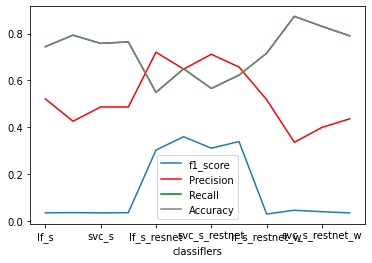

<Figure size 18000x18000 with 0 Axes>

In [138]:
import matplotlib.pyplot as plt
ax = plt.gca()
plot_df.plot(x = 'classiflers' , y ='f1_score' , ax =ax)
plot_df.plot(x = 'classiflers' , y ='Precision' , ax =ax , color = 'red')
plot_df.plot(x = 'classiflers' , y ='Recall' , ax =ax , color = 'green')
plot_df.plot(x = 'classiflers' , y ='Accuracy' , ax =ax , color = 'grey')
plt.figure(figsize = (250,250) )
plt.show()

In [131]:
clr_neam =['lf_s','rf_s','svc_s','stack_s','lf_s_resnet','rf_s_restnet','svc_s_restnet','stack_s_restnet','lf_s_restnet_w','rf_s_restnet_w','svc_s_restnet_w', 'stack_s_restnet_w']
f1 = df_perfomace['f1_score']
Precision = df_perfomace['Precision']
Recall = df_perfomace['Recall']
Recall =df_perfomace['Accuracy']


In [132]:

plot_df = pd.DataFrame(list(zip(clr_neam,f1,Precision,Recall,Recall)), columns = column )
plot_df

,classiflers,f1_score,Precision,Recall,Accuracy
0,lf_s,0.035315,0.521739,0.744340,0.744340
1,rf_s,0.036243,0.426087,0.793390,0.793390
2,svc_s,0.035022,0.486957,0.758225,0.758225
3,stack_s,0.035967,0.486957,0.764564,0.764564
4,lf_s_resnet,0.303030,0.720721,0.549266,0.549266
5,rf_s_restnet,0.360000,0.648649,0.649895,0.649895
6,svc_s_restnet,0.311024,0.711712,0.566038,0.566038
7,stack_s_restnet,0.339535,0.657658,0.622642,0.622642
8,lf_s_restnet_w,0.030255,0.518182,0.716269,0.716269
9,rf_s_restnet_w,0.046192,0.336364,0.873679,0.873679


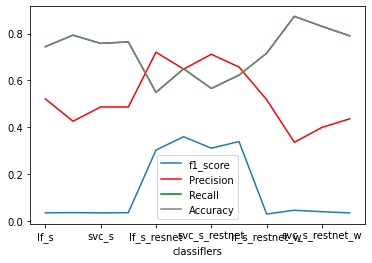

In [136]:
import matplotlib.pyplot as plt
ax = plt.gca()
plot_df.plot(x = 'classiflers' , y ='f1_score' , ax =ax)
plot_df.plot(x = 'classiflers' , y ='Precision' , ax =ax , color = 'red')
plot_df.plot(x = 'classiflers' , y ='Recall' , ax =ax , color = 'green')
plot_df.plot(x = 'classiflers' , y ='Accuracy' , ax =ax , color = 'grey')



plt.show()

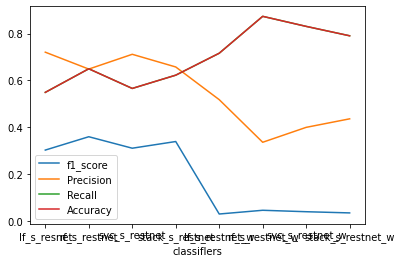

In [ ]:
plot_df.set_index('classiflers', inplace=True)
plot_df.plot()
#plot_df_t = plot_df.T
#plot_df_t

In [ ]:
plot_df_t = plot_df.T
plot_df_t


NameError: ignored

In [ ]:
# Evaluation for model
index = []
scores = {"Accuracy": [], "Balanced accuracy": []}
scoring = ["accuracy", "balanced_accuracy"]

In [ ]:
index +=["Rf + Random Undersampler"]
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(test_balanced_accuracy)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Rf + Random Undersampler,0.624981,0.626948


# Data Viz 

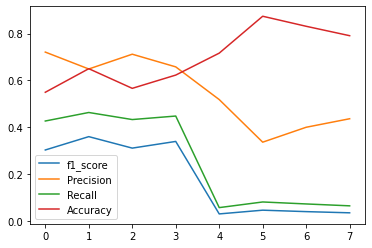

In [ ]:
import matplotlib.pyplot as plt

df_perfomace.plot()


# Download image Data


In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip

--2021-10-16 23:00:54--  https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.170.91
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.170.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24707698022 (23G) [application/zip]
Saving to: ‘ISIC_2020_Training_JPEG.zip’

ISIC_2020_Training_ 100%[===================>]  23.01G  16.0MB/s    in 24m 53s 

2021-10-16 23:25:49 (15.8 MB/s) - ‘ISIC_2020_Training_JPEG.zip’ saved [24707698022/24707698022]



In [ ]:
!unzip -q ISIC_2020_Training_JPEG.zip

In [ ]:
cd train

In [ ]:
!ls | wc -l

In [ ]:
images = glob.glob("*.jpg")
random_image = random.choice(images)
Image.open(random_image)

In [ ]:
y_train.value_counts()/np.float(len(y_train))


0    0.982302
1    0.017698
Name: target, dtype: float64

In [ ]:
X_train.head

<bound method NDFrame.head of           sex  age_approx anatom_site_general_challenge
21086    male        60.0                         torso
15202    male        55.0               lower extremity
25312  female        30.0               lower extremity
26668    male        30.0               upper extremity
16844  female        60.0                         torso
...       ...         ...                           ...
20757  female        25.0               lower extremity
32103    male        60.0                         torso
30403    male        65.0               lower extremity
21243    male        70.0               lower extremity
2732     male        50.0                         torso

[26500 rows x 3 columns]>

In [ ]:
y_test.value_counts()/np.float(len(y_test))

0    0.982644
1    0.017356
Name: target, dtype: float64

In [ ]:
X_train.isnull().sum()

sex                               52
age_approx                        55
anatom_site_general_challenge    421
dtype: int64

In [ ]:
X_test.isnull().sum()

sex                               13
age_approx                        13
anatom_site_general_challenge    106
dtype: int64

In [ ]:
# encoding labels 

lec = LabelEncoder() 
X_train['sex'] = lec.fit_transform(X_train['sex'])
X_train['anatom_site_general_challenge'] = lec.fit_transform(X_train['anatom_site_general_challenge'])
X_train

X_test['sex'] = lec.fit_transform(X_test['sex'])
X_test['anatom_site_general_challenge'] = lec.fit_transform(X_test['anatom_site_general_challenge'])


TypeError: ignored

In [ ]:
# drop null from training 
tem_train = pd.concat(X_train, y_train)
tem_train.shape

TypeError: ignored

#Temp

# New Section

In [ ]:
# Save validation performace 

lf_UnderSample_score = []
classifer_name = ['lr_Undersample']
class_report = classification_report(y_test, y_pred, output_dict=True)
lf_UnderSample_score += classifer_name
#class_report
lf_UnderSample_score += list(class_report["1"].values())[0:3]
lf_UnderSample_score.append(class_report["accuracy"])
lf_UnderSample_score

In [ ]:
# Model performace Optional
scoring = ["accuracy", "balanced_accuracy"]
cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
test_balanced_accuracy = cv_result['test_balanced_accuracy'].mean()
print(f"Accuracy score of a lr classifier: {cv_result['test_accuracy'].mean():.3f}")
print(
    f"Balanced accuracy score of a lr classifier: "
    f"{cv_result['test_balanced_accuracy'].mean():.3f}"
)

In [ ]:

conf_matrix = confusion_matrix(y_true=y_train, y_pred=lr_rs_y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt



y_pred = cross_val_predict(lr_clf, X_train, y_train, cv=10)

conf_matrix = confusion_matrix(y_true=y_train, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [ ]:
# RF
rf = RandomForestClassifier()
scoring = ["accuracy", "balanced_accuracy"]
cv_result = cross_validate(rf, X_train, y_train, scoring=scoring)
print(f"Accuracy score of a dummy classifier: {cv_result['test_accuracy'].mean():.3f}")
test_balanced_accuracy = cv_result['test_balanced_accuracy'].mean()
print(
    f"Balanced accuracy score of a dummy classifier: "
    f"{cv_result['test_balanced_accuracy'].mean():.3f}"
)



In [ ]:
# GridSearch function return best model 


param_grid = {
    "n_estimators":[10,50,250],
    "max_depth":[10, 50, 100],
    "min_samples_split" : [2, 5, 10, 15, 100],
    "min_samples_leaf" : [1, 2, 5, 10] 
}

rf_reg = RandomForestClassifier()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=5,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(X_train, y_train)
rf_reg_tuned.best_estimator_

rf = rf_reg_tuned.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 12.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Grid Search As a Function

def grid_search (clf,para,)

In [ ]:
from sklearn.metrics import accuracy_score
best_rf = rf_reg_tuned.best_estimator_
y_pred =best_rf.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Model accuracy score with default hyperparameters: 0.9826
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6511
           1       0.00      0.00      0.00       115

    accuracy                           0.98      6626
   macro avg       0.49      0.50      0.50      6626
weighted avg       0.97      0.98      0.97      6626



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# define model
model = EasyEnsembleClassifier(n_estimators=1000)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.058


In [ ]:
data = pd.read_csv('train.csv')
data.head()
print(data.shape)
print(data.columns)

(33126, 9)
Index(['image_name', 'patient_id', 'lesion_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')


In [ ]:
data = data.loc[:,['sex', 'age_approx','anatom_site_general_challenge','target']]
data.head()

,sex,age_approx,anatom_site_general_challenge,target
0,male,45.0,head/neck,0
1,female,45.0,upper extremity,0
2,female,50.0,lower extremity,0
3,female,45.0,head/neck,0
4,female,55.0,upper extremity,0


In [ ]:
data['target'].value_counts()
data['target'].value_counts()/np.float(len(data))




0    0.98237
1    0.01763
Name: target, dtype: float64

In [ ]:
data.isnull().sum()

sex                               65
age_approx                        68
anatom_site_general_challenge    527
target                             0
dtype: int64

In [ ]:
# drop null
data.dropna(subset=['sex','age_approx','anatom_site_general_challenge',], inplace=True)
data.isnull().sum()
#data['target'].value_counts()/np.float(len(data))

# 

sex                              0
age_approx                       0
anatom_site_general_challenge    0
target                           0
dtype: int64

In [ ]:
# splite data set 
X = data.drop(['target'], axis=1)

y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
X_train.isnull().sum()
#X_train

sex                              0
age_approx                       0
anatom_site_general_challenge    0
dtype: int64

In [ ]:
# Label encoder 

lec = LabelEncoder()
X_train['sex'] = lec.fit_transform(X_train['sex'])
X_train['anatom_site_general_challenge'] = lec.fit_transform(X_train['anatom_site_general_challenge'])
X_train

X_test['sex'] = lec.fit_transform(X_test['sex'])
X_test['anatom_site_general_challenge'] = lec.fit_transform(X_test['anatom_site_general_challenge'])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [ ]:
# undersampling 0 class, separated two class 

from sklearn.utils import resample,shuffle
train_data = X_train.join(y_train)
b_train = train_data.loc[train_data['target'] == 0, :]
m_train = train_data.loc[train_data['target'] == 1, :]
m_train_size = m_train.shape[0]

#size = int((0.8*m_train_size)/0.2)
#size
b_train_80 = resample(b_train, n_samples = int((0.8*m_train_size)/0.2), replace= False)
b_train_80.shape



# rejoin b_train & m_train 

train_8020 = pd.concat([b_train_80, m_train])
train_8020.shape

train_8020['target'].value_counts()/np.float(len(train_8020))
X_train = train_8020.drop(['target'], axis=1)
y_train = train_8020['target']
y_train.value_counts()

#y_test.value_counts()


0    1848
1     462
Name: target, dtype: int64

In [ ]:
# OnehotEncoding for catagorical data

categorical_cols = ['sex','anatom_site_general_challenge']
ohe = OneHotEncoder(handle_unknown = 'ignore')
array_hot_encoded = ohe.fit_transform(X_train[categorical_cols])

#conver it to df
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=X_train.index)

# Extract the column that didn't encode
data_other_cols = X_train.drop(columns=categorical_cols)

#Concate two datafraomes 

data_out = pd.concat([data_hot_encoded,data_other_cols], axis =1)
data_out



,0,age_approx
21820,"(0, 0)\t1.0\n (0, 6)\t1.0",35.0
18340,"(0, 0)\t1.0\n (0, 7)\t1.0",25.0
22781,"(0, 1)\t1.0\n (0, 6)\t1.0",60.0
27508,"(0, 1)\t1.0\n (0, 6)\t1.0",50.0
8018,"(0, 0)\t1.0\n (0, 6)\t1.0",90.0
...,...,...
13352,"(0, 1)\t1.0\n (0, 2)\t1.0",80.0
20010,"(0, 1)\t1.0\n (0, 3)\t1.0",50.0
10023,"(0, 0)\t1.0\n (0, 6)\t1.0",55.0
10994,"(0, 0)\t1.0\n (0, 6)\t1.0",55.0


In [ ]:
# RandomForestClassifier with GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score


param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[10, 50, 100],
   "min_samples_split" : [2, 5, 10, 15, 100],
    "min_samples_leaf" : [1, 2, 5, 10] 
}

rf_reg = RandomForestClassifier()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=5,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(X_train, y_train)
rf_reg_tuned.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  5.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score
best_rf = rf_reg_tuned.best_estimator_
y_pred =best_rf.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Model accuracy score with default hyperparameters: 0.9484
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6394
           1       0.07      0.17      0.10       113

    accuracy                           0.95      6507
   macro avg       0.53      0.57      0.54      6507
weighted avg       0.97      0.95      0.96      6507



In [ ]:
# Rum default model 
from sklearn.metrics import accuracy_score

svc = SVC()
svc.fit(X_train, y_train)

y_pred =svc.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9826


In [ ]:
# instantiate classifier with linear kernel and C=1.0

svc = SVC(kernel='linear', C=100.0)
svc.fit(X_train, y_train)

y_pred =svc.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9826


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6394
           1       0.00      0.00      0.00       113

    accuracy                           0.98      6507
   macro avg       0.49      0.50      0.50      6507
weighted avg       0.97      0.98      0.97      6507



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# SVM with polynomial kernel with c = 1.0
poly_svc = SVC(kernel='sigmoid', C=1000.0)
poly_svc.fit(X_train, y_train)

y_pred =poly_svc.predict(X_test)

print('Model accuracy score with polynomial kernel and c = 1000.0: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

Model accuracy score with polynomial kernel and c = 1000.0: 0.8497


In [ ]:
# SVC with Kfold 
from sklearn.model_selection import Kfold
from sklearn.model_selection import cross_val_score

X= data.drop(['target'], axis=1)
X.drop.
Y = data['target']
svc =  SVC(kernel='sigmoid', C=1000.0)
cv = KFold(n_splits =10, radom_state=42, shffle=False)
f1 = cross_val_score(svc, X_Train, y_train, scoring='f1', cv=cv, n_jobs=-1)
# report performance




              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6394
           1       0.00      0.00      0.00       113

    accuracy                           0.98      6507
   macro avg       0.49      0.50      0.50      6507
weighted avg       0.97      0.98      0.97      6507



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Recurring model run 

c_value = [50.0,100.0,1000.0]
kenel_name = ['sigmoid']

for i in range(len(kenel_name)) :
  for j in range(len(c_value)) :
     svc = SVC(kernel=kenel_name[i], C = c_value[j])
     svc.fit(X_train, y_train)
     y_pred =svc.predict(X_test)

     print('Model accuracy score with polynomial kernel and c = 1000.0: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
     print(classification_report(y_test, y_pred)) 



Model accuracy score with polynomial kernel and c = 1000.0: 0.5090
              precision    recall  f1-score   support

           0       0.97      0.51      0.67      6394
           1       0.01      0.23      0.02       113

    accuracy                           0.51      6507
   macro avg       0.49      0.37      0.34      6507
weighted avg       0.96      0.51      0.66      6507

Model accuracy score with polynomial kernel and c = 1000.0: 0.5090
              precision    recall  f1-score   support

           0       0.97      0.51      0.67      6394
           1       0.01      0.23      0.02       113

    accuracy                           0.51      6507
   macro avg       0.49      0.37      0.34      6507
weighted avg       0.96      0.51      0.66      6507

Model accuracy score with polynomial kernel and c = 1000.0: 0.5090
              precision    recall  f1-score   support

           0       0.97      0.51      0.67      6394
           1       0.01      0.23   

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

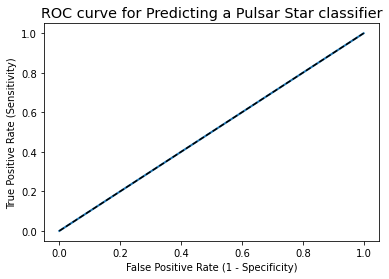

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting a Pulsar Star classifier')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()